In [19]:
from utils import *
from models import *
from data import *

import torch
import numpy as np

from tqdm.notebook import tqdm


# auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def train(model, loader, lr = 1e-3, epochs = 10, device = 'cpu'):
    
    def cuda(x):
        return x.to(device)
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = cuda(model)
    criterion = torch.nn.MSELoss()

    prog = tqdm(range(1, epochs + 1))
    for epoch in prog:
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        prog.set_description(f"Loss: {total_loss}")
        losses.append(total_loss)

# Train on 2-link Pendulum

Load Trajecotry data

In [21]:
from data import *
data_config = {
    "class": "Pendulum",
    "num_demos": 3,
    "label": 2,
    "batch_size": 100,
}
loader, data_dim, x_eq = load_data_from_config_new(data_config)

Load model and optimizer

In [22]:
model_config = {
    "type": "ELCD",
    "flow_steps": 2,
    "latent_dim": data_dim,
    "hidden_dim": 16,
}
model = get_model_from_config(model_config, data_dim=data_dim, x_eq=x_eq)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/Users/seanjaffe/Documents/Research/Extended-Linearized-Contracting-Dynamics/models/elcd.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_eq = torch.tensor(x_eq)


Eq point: tensor([[0., 0., 0., 0.]])


In [23]:
train(model, loader, lr=1e-3, epochs=100, device = 'cpu')

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/seanjaffe/Documents/Research/Extended-Linearized-Contracting-Dynamics/manifold_flow/transforms/lu.py:89: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(outputs.t(), lower, upper=False, unitriangular=True)


## Visualize Result

Select which trajectory or 4-d curve to visualize

In [24]:
traj_idx = 0

Get unshuffled data for visualization

In [25]:
traj_x  = loader.dataset.pos[traj_idx].transpose(1,0)
traj_x_dot = loader.dataset.vel[traj_idx].transpose(1,0)

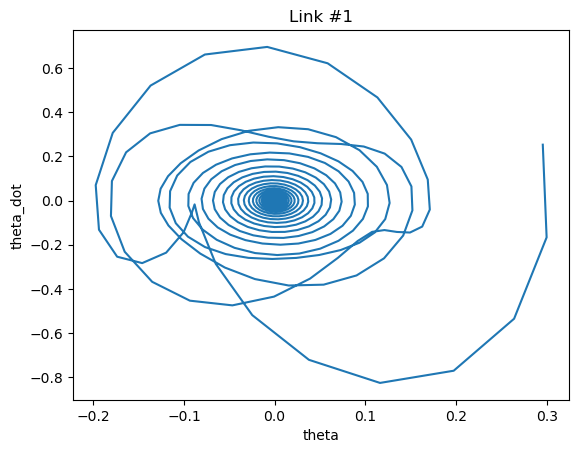

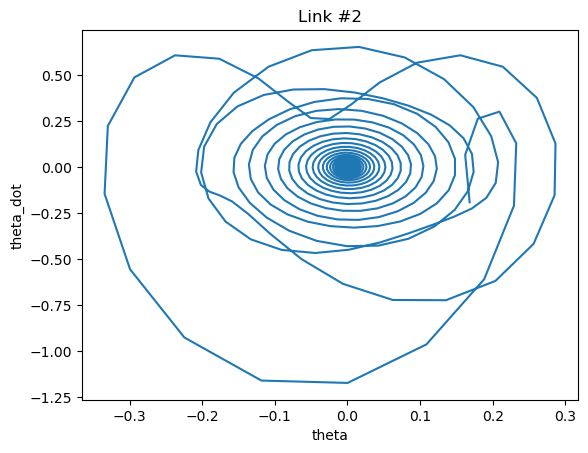

In [26]:
for s in range(2):
    # pendulum trajectories are theta_1, theta_2, theta_1_dot, theta_2_dot
    plt.plot([x[s] for x in traj_x], [x[data_dim//2  + s] for x in traj_x]) 
    plt.title(f'Link #{s+1}')
    plt.xlabel('theta')
    plt.ylabel('theta_dot')
    plt.show()


Get model's prediction for velocity at every point along data trajectory.

In [27]:
x_pred = model(traj_x).detach().numpy()

Generate new trajectory form model starting at data trajectory initial point.

In [28]:
f = lambda x, dt: single_ode45_step(model,x, dt)
x0 = loader.dataset.pos[traj_idx,:,0].unsqueeze(0)

Y = forward_step_until_converge(f=f, x0=x0, dt = 0.05).detach().numpy()

Plot results.

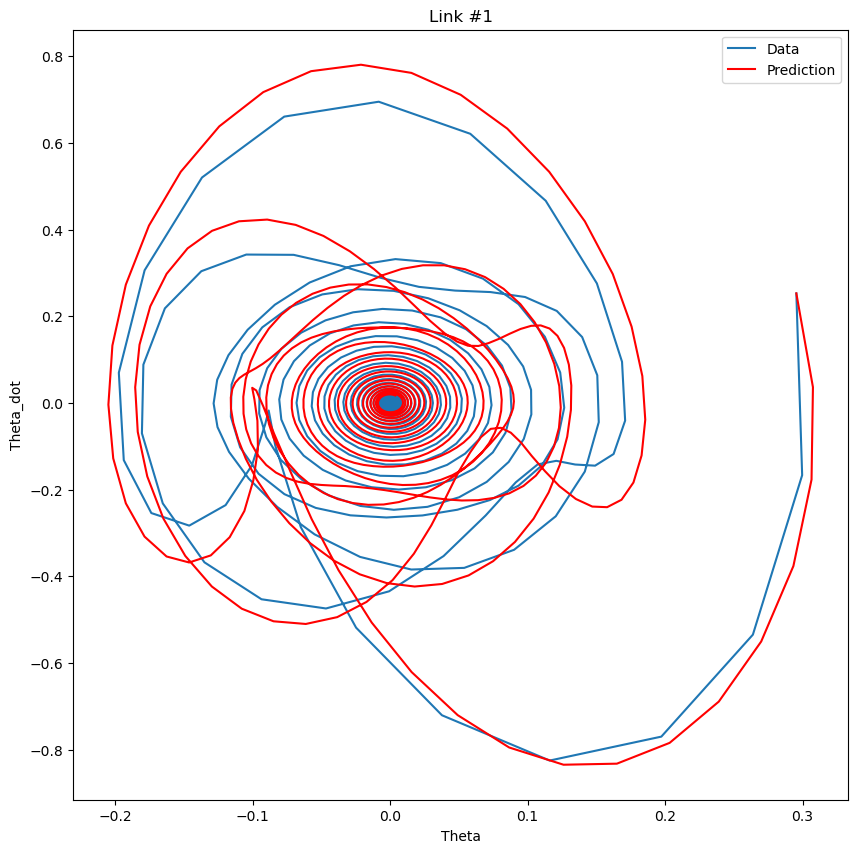

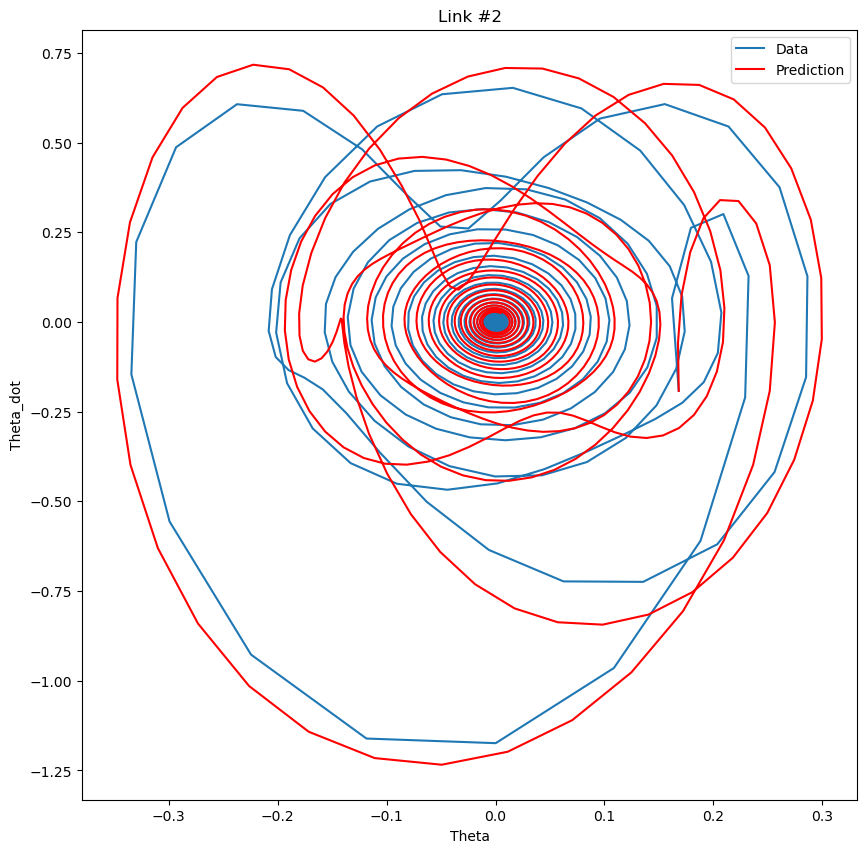

In [31]:

for s in range(data_dim // 2):

  f, ax = plt.subplots(1,1, figsize=(10,10)) 
  every_other = 1 # plot predictions along every 10th point of data trajectory


  # set Title
  ax.set_title(f'Link #{s+1}')
  ax.set_xlabel('Theta')
  ax.set_ylabel('Theta_dot')
  plt.plot([x[s] for x in traj_x], [x[data_dim//2  + s] for x in traj_x], label='Data') 


  plt.plot(Y[:,0,s ], Y[:,0, data_dim // 2  + s], color='red', label='Prediction')
  plt.legend()
  plt.show()